# Exploring the initialisation maps
In this tutorial we will explore the initialisation maps offered in `plasticparcels`. Descriptions of these initialisation maps can be found [here](https://plastic.oceanparcels.org/en/latest/initialisationmaps.html). For your particular model, you can generate these maps using the `create_release_maps.py` script found in `plasticparcels.scripts`. Here, we will download the file for the `NEMO0083` model. We will also make a dummy fieldset in order to show how to create particle sets from these initialisation maps.

In [1]:
# Library imports
from datetime import datetime, timedelta
import os
os.chdir('../../')
# Parcels and PlasticParcels imports
import plasticparcels as pp

# Plotting imports
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import pandas as pd
import numpy as np

from parcels import FieldSet

In [2]:
# Load the model settings
settings = {"release_maps": {
                "coastal": None,
                "rivers": None,
                "fisheries": None,
                "global_concentrations": None,},
            "unbeaching": {
                "filename": None,
            }
}

# Set some plastic settings, for use later in the tutorial
settings['plastictype'] = {
    'wind_coefficient' : 0.01, # Percentage of wind to apply to particles
    'plastic_diameter' : 0.001, # Plastic particle diameter (m)
    'plastic_density' : 1030., # Plastic particle density (kg/m^3)
}

In [3]:
# Download the mask and release data
settings = pp.utils.download_plasticparcels_dataset('NEMO0083', settings, 'input_data')

In [4]:
# Create a dummy fieldset
def generate_dummy_fieldset(xdim, ydim, zdim=1, tdim=1):
    lon = np.linspace(0., 10., xdim, dtype=np.float32)
    lat = np.linspace(0., 10., ydim, dtype=np.float32)
    depth = np.zeros(zdim, dtype=np.float32)
    time = np.zeros(tdim, dtype=np.float64)
    if zdim == 1 and tdim == 1:
        U, V = np.meshgrid(lon, lat)
        dimensions = {'lat': lat, 'lon': lon}
    else:
        U = np.ones((tdim, zdim, ydim, xdim))
        V = np.ones((tdim, zdim, ydim, xdim))
        dimensions = {'lat': lat, 'lon': lon, 'depth': depth, 'time': time}
    data = {'U': np.array(U, dtype=np.float32), 'V': np.array(V, dtype=np.float32)}

    fieldset = FieldSet.from_data(data, dimensions)
    return fieldset

fieldset = generate_dummy_fieldset(10,10)

## Explore the `coastal` initialisation map
The `coastal` initialisation map provides locations of plastic pollution generated from mismanaged plastic waste near coastal populations. We will start by loading in the data using `pandas`.

In [5]:
coastal_ds = pd.read_csv(settings['release_maps']['coastal'])

In [6]:
coastal_ds

,Unnamed: 0,Continent,Region,Subregion,Country,Longitude,Latitude,Area[km2],PopulationDensity,Economic status,Mismanaged plastic waste [kg/person/day],MPW_Cell
0,0,Asia,Asia,Western Asia,Yemen,53.583333,12.239176,8.201038,17.718029,LMI,0.076627,11.134375
1,1,Asia,Asia,Western Asia,Yemen,53.666667,12.239176,8.201038,17.718029,LMI,0.076627,11.134375
2,2,Asia,Asia,Western Asia,Yemen,53.750000,12.239176,8.201038,17.718029,LMI,0.076627,11.134375
3,3,Asia,Asia,Western Asia,Yemen,53.833333,12.239176,8.201038,17.718029,LMI,0.076627,11.134375
4,4,Asia,Asia,Western Asia,Yemen,43.416667,12.320603,8.195966,11.842899,LMI,0.076627,7.437719
...,...,...,...,...,...,...,...,...,...,...,...,...
87854,87854,North America,Americas,Caribbean,Sint Maarten,-62.833333,17.869711,7.778406,421.876770,HIC,0.005100,16.735158
87855,87855,North America,Americas,Caribbean,Sint Maarten,-62.666667,17.869711,7.778406,0.000000,HIC,0.005100,0.000000
87856,87856,North America,Americas,Caribbean,Sint Maarten,-62.833333,17.949007,7.771451,421.876770,HIC,0.005100,16.720194
87857,87857,North America,Americas,Caribbean,Sint Maarten,-62.666667,17.949007,7.771451,0.000000,HIC,0.005100,0.000000


The `coastal` dataset can be queried using geographic information, as well as population density and economic status information.

In [7]:
print("Unique Continents:", coastal_ds['Continent'].unique())
print("Unique Regions:", coastal_ds['Region'].unique())
print("Unique Subregions:", coastal_ds['Subregion'].unique())
print("Unique Economic status:", coastal_ds['Economic status'].unique())

Unique Continents: ['Asia' 'South America' 'Europe' 'Oceania' 'North America'
 'Seven seas (open ocean)' 'Africa' 'Antarctica']
Unique Regions: ['Asia' 'Americas' 'Europe' 'Oceania' 'Africa' 'Antarctica']
Unique Subregions: ['Western Asia' 'South-Eastern Asia' 'South America' 'Southern Europe'
 'Melanesia' 'Micronesia' 'Caribbean' 'Polynesia' 'Northern America'
 'Seven seas (open ocean)' 'Northern Europe' 'Eastern Europe'
 'Northern Africa' 'Western Africa' 'Eastern Africa' 'Eastern Asia'
 'Southern Asia' 'Southern Africa' 'Middle Africa' 'Central America'
 'Australia and New Zealand' 'Western Europe' 'Antarctica']
Unique Economic status: ['LMI' 'HIC' nan 'UMI' 'LI']


To subset the data in `plasticparcels`, you simply provide one or more of the following settings:
```python
settings['release'] = {
    'initialisation_type': 'coastal',
    'continent': 'Europe',
    'region': 'Europe',
    'subregion': 'Northern Europe',
    'country': 'Netherlands',
    'economicstatus': 'HIC',
}
```
For example, if you wanted to create an initialisation map for coastal plastic pollution along all Northern European coastlines, you can use:

In [29]:
settings['release'] = {
    'initialisation_type': 'coastal',
    'subregion': 'Northern Europe',
}


In [30]:
pset = pp.create_particleset_from_map(fieldset, settings)

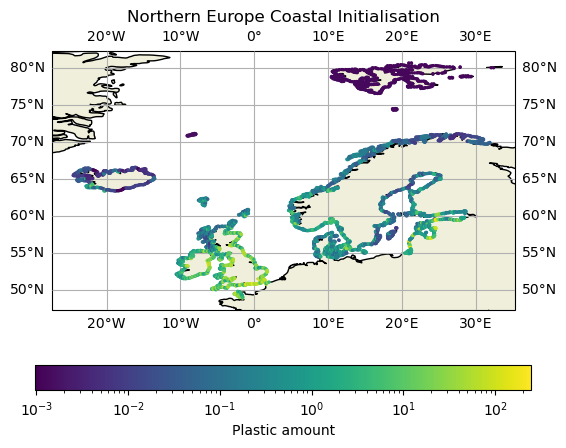

In [33]:
# Plot the initialisation map
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=1)
ax.coastlines(zorder=2)
ax.gridlines(draw_labels=True, zorder=3)
cb = ax.scatter(pset.lon, pset.lat, c=pset.plastic_amount, s=2, transform=ccrs.PlateCarree(), zorder=4, norm=LogNorm(vmin=pset.plastic_amount.min(), vmax=pset.plastic_amount.max()))
plt.title("Northern Europe Coastal Initialisation")
plt.colorbar(cb, label='Plastic amount', orientation='horizontal')
plt.show()

## Explore the `rivers` initialisation map
The `rivers` initialisation map provides locations of plastic pollution generated from mismanaged plastic waste that ends up in the ocean via river outflow. We will start by loading in the data using `pandas`.

In [8]:
rivers_ds = pd.read_csv(settings['release_maps']['rivers'])

In [9]:
rivers_ds

,Unnamed: 0,Continent,Region,Subregion,Country,Longitude,Latitude,Emissions
0,0,Oceania,Oceania,Australia and New Zealand,New Zealand,168.833333,-46.569603,0.164904
1,1,Oceania,Oceania,Australia and New Zealand,New Zealand,168.333333,-46.454902,0.124932
2,2,Oceania,Oceania,Australia and New Zealand,New Zealand,168.333333,-46.454902,1.213370
3,3,Oceania,Oceania,Australia and New Zealand,New Zealand,168.000000,-46.339961,0.121138
4,4,Oceania,Oceania,Australia and New Zealand,New Zealand,169.833333,-46.397461,0.197533
...,...,...,...,...,...,...,...,...
31814,31814,Europe,Europe,Eastern Europe,Russian Federation,158.768783,52.970829,3.937440
31815,31815,Europe,Europe,Eastern Europe,Russian Federation,158.598172,52.908962,3.821710
31816,31816,Europe,Europe,Eastern Europe,Russian Federation,158.768783,52.970829,9.836130
31817,31817,Europe,Europe,Eastern Europe,Russian Federation,158.598172,52.908962,1.693040


For now, the `rivers` dataset can only be queried using geographic information.

In [10]:
print("Unique Continents:", rivers_ds['Continent'].unique())
print("Unique Regions:", rivers_ds['Region'].unique())
print("Unique Subregions:", rivers_ds['Subregion'].unique())

Unique Continents: ['Oceania' 'Asia' 'Europe' 'Africa' 'South America' 'North America']
Unique Regions: ['Oceania' 'Asia' 'Europe' 'Africa' 'Americas']
Unique Subregions: ['Australia and New Zealand' 'Melanesia' 'South-Eastern Asia' 'Micronesia'
 'Eastern Asia' 'Southern Asia' 'Eastern Europe' 'Southern Africa'
 'Eastern Africa' 'Middle Africa' 'Western Africa' 'Northern Africa'
 'Southern Europe' 'Western Asia' 'Central Asia' 'Western Europe'
 'Northern Europe' 'South America' 'Central America' 'Caribbean'
 'Northern America']


To subset the data in `plasticparcels`, you simply provide one or more of the following settings:
```python
settings['release'] = {
    'initialisation_type': 'rivers',
    'continent': 'Europe',
    'region': 'Europe',
    'subregion': 'Northern Europe',
    'country': 'Netherlands',
}
```
For example, if you wanted to create an initialisation map for riverine plastic pollution from Australian and New Zealand rivers, you can use:

In [34]:
settings['release'] = {
    'initialisation_type': 'rivers',
    'subregion': 'Australia and New Zealand',
}

In [35]:
pset = pp.create_particleset_from_map(fieldset, settings)

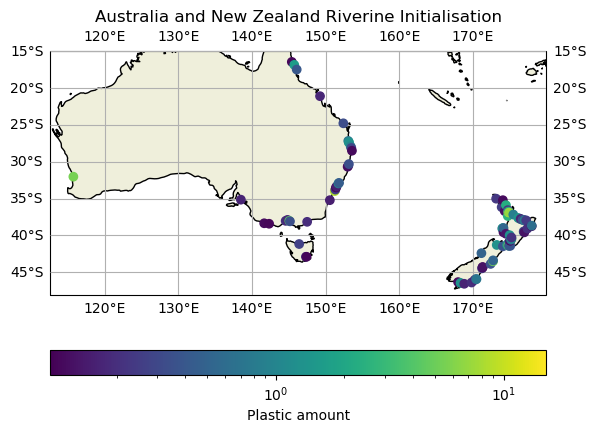

In [38]:
# Plot the initialisation map
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=1)
ax.coastlines(zorder=2)
ax.gridlines(draw_labels=True, zorder=3)
cb = ax.scatter(pset.lon, pset.lat, c=pset.plastic_amount, transform=ccrs.PlateCarree(), zorder=4, norm=LogNorm(vmin=pset.plastic_amount.min(), vmax=pset.plastic_amount.max()))
plt.title("Australia and New Zealand Riverine Initialisation")
plt.colorbar(cb, label='Plastic amount', orientation='horizontal')
plt.show()

## Explore the `fisheries` initialisation map
The `fisheries` initialisation map provides locations of plastic pollution generated from fishing related activity, which we assume to be proportional to the number of fishing hours spent in a given location. We will start by loading in the data using `pandas`.

In [39]:
fisheries_ds = pd.read_csv(settings['release_maps']['fisheries'])

In [40]:
fisheries_ds

,Unnamed: 0,Longitude,Latitude,Flag,Geartype,Month,Continent,Region,Subregion,Country,fishing_hours
0,0,-179.998299,53.902935,USA,pots_and_traps,2020-09-01,North America,Americas,Northern America,United States,0.1477
1,1,-179.998244,64.513663,CYP,trawlers,2020-08-01,Asia,Asia,Western Asia,Cyprus,0.5673
2,2,-179.998244,64.513663,KOR,trawlers,2020-10-01,Asia,Asia,Eastern Asia,Republic of Korea,0.9904
3,3,-179.998244,64.513663,RUS,fishing,2020-09-01,Europe,Europe,Eastern Europe,Russian Federation,4.9353
4,4,-179.998244,64.513663,RUS,purse_seines,2020-09-01,Europe,Europe,Eastern Europe,Russian Federation,2.6808
...,...,...,...,...,...,...,...,...,...,...,...
5975965,5975965,180.000000,18.818880,TWN,drifting_longlines,2020-12-01,Asia,Asia,Eastern Asia,Taiwan,4.8436
5975966,5975966,180.000000,19.370117,TWN,drifting_longlines,2020-12-01,Asia,Asia,Eastern Asia,Taiwan,1.2607
5975967,5975967,180.000000,19.684276,CHN,squid_jigger,2020-06-01,Asia,Asia,Eastern Asia,China,1.7861
5975968,5975968,180.000000,22.329116,TWN,drifting_longlines,2020-02-01,Asia,Asia,Eastern Asia,Taiwan,0.4816


The `fisheries` dataset can be queried using geographic information and country flag. The 'gear type' option will be added in upcoming release.

In [41]:
print("Unique Continents:", fisheries_ds['Continent'].unique())
print("Unique Regions:", fisheries_ds['Region'].unique())
print("Unique Subregions:", fisheries_ds['Subregion'].unique())

Unique Continents: ['North America' 'Asia' 'Europe' 'Oceania' 'Africa' 'South America'
 'Seven seas (open ocean)']
Unique Regions: ['Americas' 'Asia' 'Europe' 'Oceania' 'Africa']
Unique Subregions: ['Northern America' 'Western Asia' 'Eastern Asia' 'Eastern Europe'
 'Melanesia' 'Australia and New Zealand' 'Southern Europe' 'Micronesia'
 'Western Africa' 'Polynesia' 'South America' 'Central America'
 'Northern Europe' 'Caribbean' 'Western Europe' 'Southern Asia'
 'South-Eastern Asia' 'Southern Africa' 'Middle Africa' 'Eastern Africa'
 'Northern Africa']


To subset the data in `plasticparcels`, you simply provide one or more of the following settings:
```python
settings['release'] = {
    'initialisation_type': 'fisheries',
    'continent': 'Europe',
    'region': 'Europe',
    'subregion': 'Northern Europe',
    'country': 'Netherlands',
}
```
For example, if you wanted to create an initialisation map for fisheries related plastic pollution from the continent of Asia, you can use:

In [42]:
settings['release'] = {
    'initialisation_type': 'fisheries',
    'continent': 'Asia',
}

In [43]:
pset = pp.create_particleset_from_map(fieldset, settings)

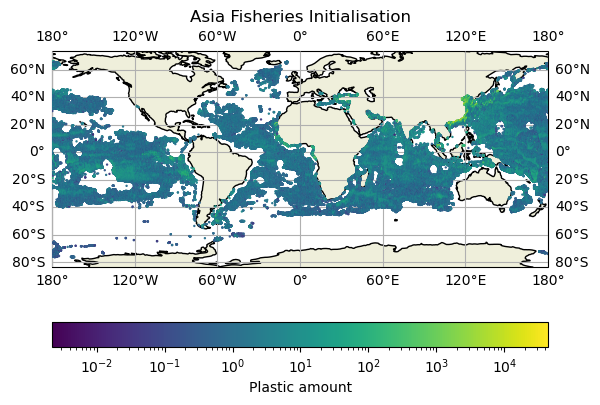

In [46]:
# Plot the initialisation map
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=1)
ax.coastlines(zorder=2)
ax.gridlines(draw_labels=True, zorder=3)
cb = ax.scatter(pset.lon, pset.lat, c=pset.plastic_amount, s=0.5, transform=ccrs.PlateCarree(), zorder=4, norm=LogNorm(vmin=pset.plastic_amount.min(), vmax=pset.plastic_amount.max()))
plt.title("Asian Fisheries Initialisation")
plt.colorbar(cb, label='Plastic amount', orientation='horizontal')
plt.show()